# Extracellular Electrophysiology Data Quick Start

A short introduction to the Visual Coding Neuropixels data and SDK. For more information, see the full reference notebook.

Contents
-------------
* <a href='#peristimulus-time-histograms'>peristimulus time histograms</a>
* <a href='#image-classification'>image classification</a>

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

/opt/hostedtoolcache/Python/3.8.17/x64/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The `EcephysProjectCache` is the main entry point to the Visual Coding Neuropixels dataset. It allows you to download data for individual recording sessions and view cross-session summary information.

In [2]:
# Example cache directory path, it determines where downloaded data will be stored
output_dir = '/local1/ecephys_cache_dir/'

In [4]:
# this path determines where downloaded data will be stored
manifest_path = os.path.join(output_dir, "manifest.json")

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

print(cache.get_all_session_types())

['brain_observatory_1.1', 'functional_connectivity']


This dataset contains sessions in which two sets of stimuli were presented. The `"brain_observatory_1.1"` sessions are (almost exactly) the same as Visual Coding 2P sessions.

In [5]:
sessions = cache.get_session_table()
brain_observatory_type_sessions = sessions[sessions["session_type"] == "brain_observatory_1.1"]
brain_observatory_type_sessions.tail()

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
773418906,2019-10-03T00:00:00Z,757329624,brain_observatory_1.1,124.0,F,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,546,2232,6,"[PPT, NOT, SUB, ProS, CA1, VISam, nan, APN, DG..."
791319847,2019-10-03T00:00:00Z,769360779,brain_observatory_1.1,116.0,M,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,555,2229,6,"[APN, DG, CA1, VISam, nan, LP, TH, VISpm, POL,..."
797828357,2019-10-03T00:00:00Z,776061251,brain_observatory_1.1,107.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,611,2232,6,"[PPT, MB, APN, NOT, HPF, ProS, CA1, VISam, nan..."
798911424,2019-10-03T00:00:00Z,775876828,brain_observatory_1.1,110.0,F,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,825,2233,6,"[APN, TH, Eth, LP, DG, HPF, CA3, CA1, VISrl, n..."
799864342,2019-10-03T00:00:00Z,772616823,brain_observatory_1.1,129.0,M,wt/wt,604,2233,6,"[APN, POL, LP, DG, CA1, VISrl, nan, LGd, CA3, ..."


### peristimulus time histograms

We are going to pick a session arbitrarily and download its spike data.

In [6]:
session_id = 791319847
session = cache.get_session_data(session_id)

Downloading: 100%|██████████| 2.32G/2.32G [01:46<00:00, 21.8MB/s]


We can get a high-level summary of this session by acessing its `metadata` attribute:

In [7]:
session.metadata

{'specimen_name': 'Vip-IRES-Cre;Ai32-417678',
 'session_type': 'brain_observatory_1.1',
 'full_genotype': 'Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt',
 'sex': 'M',
 'age_in_days': 116.0,
 'rig_equipment_name': 'NP.1',
 'num_units': 555,
 'num_channels': 2229,
 'num_probes': 6,
 'num_stimulus_presentations': 70931,
 'session_start_time': datetime.datetime(2019, 1, 8, 13, 55, 1, tzinfo=tzoffset(None, -28800)),
 'ecephys_session_id': 791319847,
 'structure_acronyms': ['VISpm',
  nan,
  'LP',
  'TH',
  'DG',
  'CA1',
  'CA3',
  'CA2',
  'VISl',
  'ZI',
  'LGv',
  'VISal',
  'APN',
  'POL',
  'VISrl',
  'VISam',
  'LGd',
  'ProS',
  'SUB',
  'VISp'],
 'stimulus_names': ['spontaneous',
  'gabors',
  'flashes',
  'drifting_gratings',
  'natural_movie_three',
  'natural_movie_one',
  'static_gratings',
  'natural_scenes',
  'drifting_gratings_contrast']}

We can also take a look at how many units were recorded in each brain structure:

In [8]:
session.structurewise_unit_counts

VISp     93
CA1      85
VISrl    58
VISl     56
VISam    49
VISal    43
SUB      41
CA3      33
DG       32
VISpm    17
LGv      16
LP        9
LGd       8
TH        4
ZI        4
CA2       3
POL       3
ProS      1
Name: ecephys_structure_acronym, dtype: int64

Now that we've gotten spike data, we can create peristimulus time histograms.

In [9]:
presentations = session.get_stimulus_table("flashes")
units = session.units[session.units["ecephys_structure_acronym"] == 'VISp']

time_step = 0.01
time_bins = np.arange(-0.1, 0.5 + time_step, time_step)

histograms = session.presentationwise_spike_counts(
    stimulus_presentation_ids=presentations.index.values,  
    bin_edges=time_bins,
    unit_ids=units.index.values
)

histograms.coords

Coordinates:
  * stimulus_presentation_id         (stimulus_presentation_id) int64 3647 .....
  * time_relative_to_stimulus_onset  (time_relative_to_stimulus_onset) float64 ...
  * unit_id                          (unit_id) int64 951061537 ... 951062679

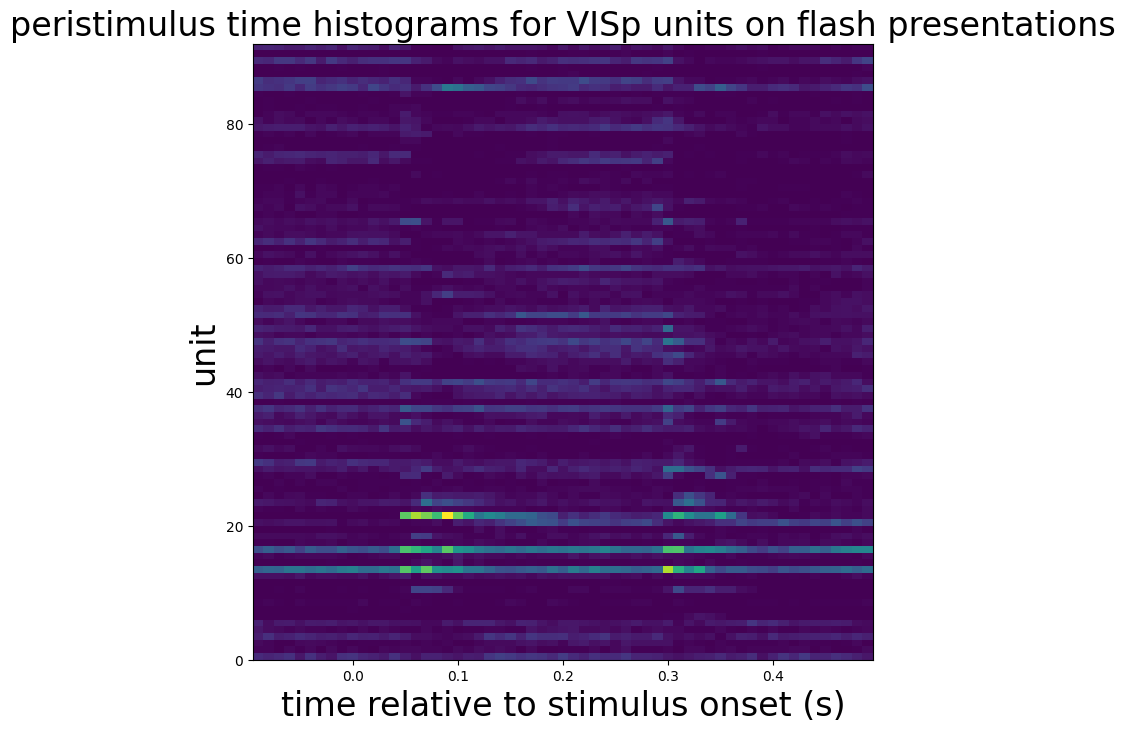

In [10]:
mean_histograms = histograms.mean(dim="stimulus_presentation_id")

fig, ax = plt.subplots(figsize=(8, 8))
ax.pcolormesh(
    mean_histograms["time_relative_to_stimulus_onset"], 
    np.arange(mean_histograms["unit_id"].size),
    mean_histograms.T, 
    vmin=0,
    vmax=1
)

ax.set_ylabel("unit", fontsize=24)
ax.set_xlabel("time relative to stimulus onset (s)", fontsize=24)
ax.set_title("peristimulus time histograms for VISp units on flash presentations", fontsize=24)

plt.show()

### image classification

First, we need to extract spikes. We will do using `EcephysSession.presentationwise_spike_times`, which returns spikes annotated by the unit that emitted them and the stimulus presentation during which they were emitted.

In [11]:
scene_presentations = session.get_stimulus_table("natural_scenes")
visp_units = session.units[session.units["ecephys_structure_acronym"] == "VISp"]

spikes = session.presentationwise_spike_times(
    stimulus_presentation_ids=scene_presentations.index.values,
    unit_ids=visp_units.index.values[:]
)

spikes

,stimulus_presentation_id,unit_id,time_since_stimulus_presentation_onset
spike_time,,,
5914.084307,51355,951061801,0.001665
5914.085207,51355,951062307,0.002565
5914.087241,51355,951062610,0.004598
5914.090107,51355,951061993,0.007465
5914.090407,51355,951062605,0.007765
...,...,...,...
8573.801313,68228,951061801,0.244631
8573.801613,68228,951062175,0.244931
8573.805379,68228,951062898,0.248698


Next, we will convert these into a num_presentations X num_units matrix, which will serve as our input data.

In [12]:
spikes["count"] = np.zeros(spikes.shape[0])
spikes = spikes.groupby(["stimulus_presentation_id", "unit_id"]).count()

design = pd.pivot_table(
    spikes, 
    values="count", 
    index="stimulus_presentation_id", 
    columns="unit_id", 
    fill_value=0.0,
    aggfunc=np.sum
)

design

unit_id,951061537,951061549,951061556,951061568,951061574,951061607,951061637,951061643,951061649,951061655,...,951062587,951062600,951062605,951062610,951062647,951062679,951062808,951062833,951062854,951062898
stimulus_presentation_id,,,,,,,,,,,,,,,,,,,,,
51355,1,3,1,1,2,3,2,1,2,0,...,15,0,15,5,11,5,0,0,2,1
51356,2,0,1,2,2,1,1,3,4,0,...,10,0,10,3,16,3,1,0,2,0
51357,0,0,1,1,1,1,1,1,0,0,...,7,0,13,0,14,6,12,3,2,5
51358,0,2,1,3,4,1,0,2,1,2,...,6,0,11,7,8,3,0,0,0,3
51359,1,0,1,2,2,1,0,1,0,2,...,7,0,15,4,10,5,11,2,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68224,2,0,4,2,1,0,1,0,1,0,...,2,0,11,16,3,0,4,0,0,1
68225,0,0,9,0,2,0,1,0,0,0,...,5,0,13,5,5,0,3,0,0,5
68226,1,0,1,3,2,0,1,0,0,0,...,15,0,12,2,10,0,4,0,1,5


... with targets being the numeric identifiers of the images presented.

In [13]:
targets = scene_presentations.loc[design.index.values, "frame"]
targets

stimulus_presentation_id
51355     14.0
51356      0.0
51357      8.0
51358    106.0
51359      8.0
         ...  
68224     35.0
68225     35.0
68226     73.0
68227     95.0
68228     95.0
Name: frame, Length: 5950, dtype: object

In [14]:
!pip install scikit-learn

from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

In [15]:
design_arr = design.values.astype(float)
targets_arr = targets.values.astype(int)

labels = np.unique(targets_arr)

In [16]:
accuracies = []
confusions = []

for train_indices, test_indices in KFold(n_splits=5).split(design_arr):
    
    clf = svm.SVC(gamma="scale", kernel="rbf")
    clf.fit(design_arr[train_indices], targets_arr[train_indices])
    
    test_targets = targets_arr[test_indices]
    test_predictions = clf.predict(design_arr[test_indices])
    
    accuracy = 1 - (np.count_nonzero(test_predictions - test_targets) / test_predictions.size)
    print(accuracy)
    
    accuracies.append(accuracy)
    confusions.append(confusion_matrix(y_true=test_targets, y_pred=test_predictions, labels=labels))

0.41428571428571426
0.4966386554621849
0.49747899159663866
0.5067226890756302
0.473109243697479


In [17]:
print(f"mean accuracy: {np.mean(accuracy)}")
print(f"chance: {1/labels.size}")

mean accuracy: 0.473109243697479
chance: 0.008403361344537815


###### imagewise performance

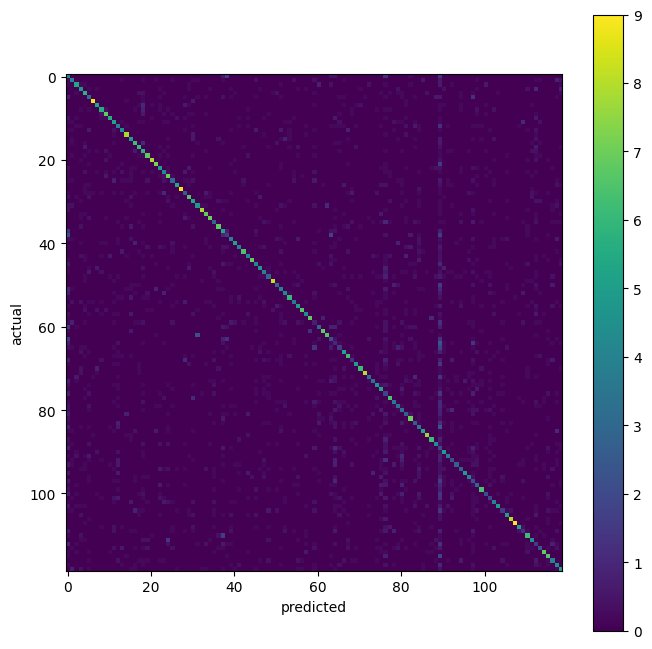

In [18]:
mean_confusion = np.mean(confusions, axis=0)

fig, ax = plt.subplots(figsize=(8, 8))

img = ax.imshow(mean_confusion)
fig.colorbar(img)

ax.set_ylabel("actual")
ax.set_xlabel("predicted")

plt.show()

Downloading: 100%|██████████| 1.08M/1.08M [00:00<00:00, 1.76MB/s]
Downloading: 100%|██████████| 1.08M/1.08M [00:00<00:00, 2.70MB/s]


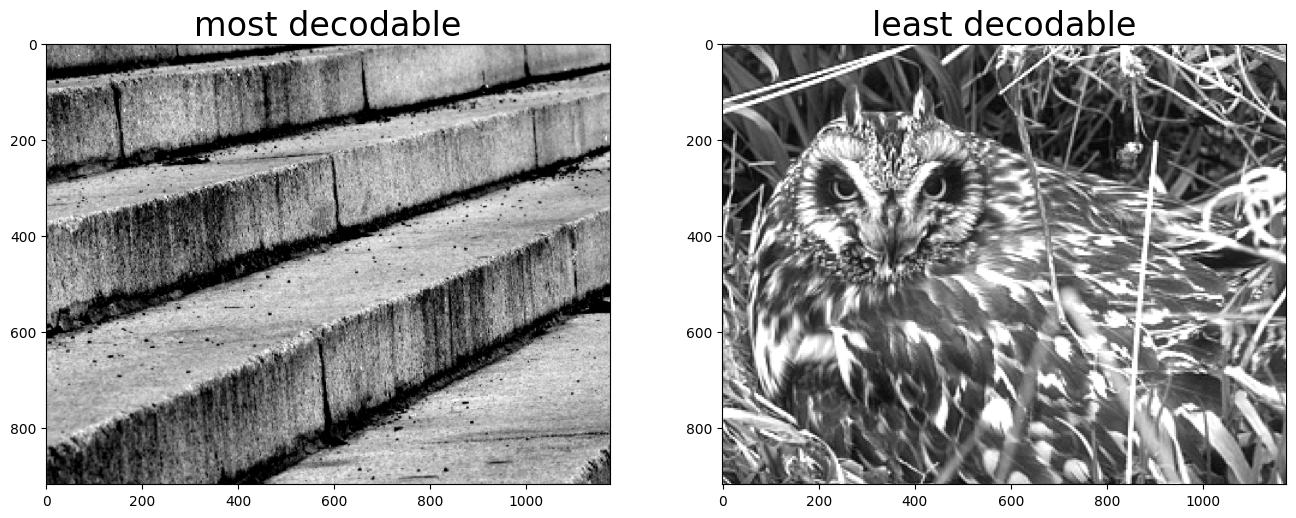

In [19]:
best = labels[np.argmax(np.diag(mean_confusion))]
worst = labels[np.argmin(np.diag(mean_confusion))]

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

best_image = cache.get_natural_scene_template(best)
ax[0].imshow(best_image, cmap=plt.cm.gray)
ax[0].set_title("most decodable", fontsize=24)

worst_image = cache.get_natural_scene_template(worst)
ax[1].imshow(worst_image, cmap=plt.cm.gray)
ax[1].set_title("least decodable", fontsize=24)


plt.show()